In [1]:
!pip3 uninstall -y kaggle
!pip3 install --upgrade pip
!pip3 install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
     |████████████████████████████████| 61kB 2.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=068ec6e6fb4bce9979520c12869a5b0d5c59faf81a7203f5f8bc604f54306601
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [2]:
!mkdir /root/.kaggle
## Upload the kaggle.json file.
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip
!rm plant-seedlings-classification.zip sample_submission.csv

 99% 1.67G/1.69G [00:15<00:00, 129MB/s]
100% 1.69G/1.69G [00:15<00:00, 114MB/s]
Archive:  plant-seedlings-classification.zip
  inflating: sample_submission.csv   
  inflating: test/0021e90e4.png      
  inflating: test/003d61042.png      
  inflating: test/007b3da8b.png      
  inflating: test/0086a6340.png      
  inflating: test/00c47e980.png      
  inflating: test/00d090cde.png      
  inflating: test/00ef713a8.png      
  inflating: test/01291174f.png      
  inflating: test/026716f9b.png      
  inflating: test/02cfeb38d.png      
  inflating: test/03566743d.png      
  inflating: test/03a2ee656.png      
  inflating: test/03e322a29.png      
  inflating: test/03ef36742.png      
  inflating: test/043449b0b.png      
  inflating: test/0437393b1.png      
  inflating: test/04814f36d.png      
  inflating: test/05341a8a6.png      
  inflating: test/060450d79.png      
  inflating: test/060f1dc84.png      
  inflating: test/0625f063b.png      
  inflating: test/063363305.png      
 

In [0]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
from keras import regularizers

import random
import matplotlib.pyplot as plt
import sys
import numpy as np

import os
import cv2
import math
import itertools
import pandas as pd
import random
from scipy import ndarray

# image processing library
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io

from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.backend import set_session,tensorflow_backend

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
config.gpu_options.per_process_gpu_memory_fraction = 0.5
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

## Constants

In [0]:
TRAIN_DIRECTORY = "train"
TEST_DIRECTORY = "test"
IMG_HEIGHT = 80
IMG_WIDTH = 80
CATEGORIES = os.listdir(TRAIN_DIRECTORY)
num_classes = len(CATEGORIES)

FILTER = True

In [10]:
#get list of folders in the train directory and count contents
files_count = pd.DataFrame(columns=['Label','Count'])
for name in os.listdir(TRAIN_DIRECTORY):
    files_count = files_count.append({'Label': TRAIN_DIRECTORY + '/' + name, 'Count': len(os.listdir(TRAIN_DIRECTORY + '/' + name))}, ignore_index=True)
    print(name)

Common wheat
Sugar beet
Small-flowered Cranesbill
Black-grass
Scentless Mayweed
Charlock
Shepherds Purse
Cleavers
Loose Silky-bent
Common Chickweed
Fat Hen
Maize


In [11]:
files_count

,Label,Count
0,train/Common wheat,221
1,train/Sugar beet,385
2,train/Small-flowered Cranesbill,496
3,train/Black-grass,263
4,train/Scentless Mayweed,516
5,train/Charlock,390
6,train/Shepherds Purse,231
7,train/Cleavers,287
8,train/Loose Silky-bent,654
9,train/Common Chickweed,611


## Load and prepare data

In [85]:
path_to_all_files = TRAIN_DIRECTORY + '/*/*.png' 
files = glob(path_to_all_files)

trainImg = []
trainLabel = []
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    trainImg.append(cv2.resize(cv2.imread(img), (IMG_WIDTH, IMG_HEIGHT)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

print(trainImg.shape)
print(trainLabel.shape)

(6290, 80, 80, 3)
(6290, 1)


In [0]:
trainLabel.to_csv('labels.csv')

In [86]:
path_to_all_files = TEST_DIRECTORY + '/*.png' 
files = glob(path_to_all_files)

testImg = []
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    testImg.append(cv2.resize(cv2.imread(img), (IMG_WIDTH, IMG_HEIGHT)))  # Get image (with resizing)

testImg = np.asarray(testImg)  # Train images set

print(testImg.shape)


(794, 80, 80, 3)


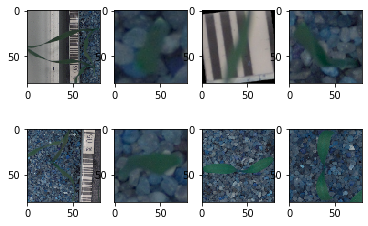

In [87]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i*100])

## Cleaning data

### Remove background

In [0]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [0]:
clearTrainImg = []
for img in trainImg:
    image = sharpen_image(segment_plant(img))
    clearTrainImg.append(image)
    
clearTrainImg = np.asarray(clearTrainImg)

In [0]:
clearTestImg = []
for img in testImg:
    image = sharpen_image(segment_plant(img))
    clearTestImg.append(image)
    
clearTestImg = np.asarray(clearTestImg)

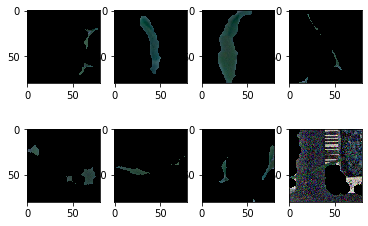

In [91]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i*10])

## Normalise and change labels to categorical

In [0]:
#Use filtered data or not
if FILTER == False:
    trainImg = trainImg / 255
    testImg = testImg / 255
else:
    trainImg = clearTrainImg / 255
    testImg = clearTestImg / 255

In [ ]:
le = preprocessing.LabelEncoder()
encodeTrainLabels = le.fit_transform(trainLabel[0])
clearTrainLabel = to_categorical(encodeTrainLabels)

### Train and validation, image generator

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(trainImg, clearTrainLabel, 
                                                test_size=0.2, random_state=33, 
                                                stratify = clearTrainLabel)

In [0]:
BATCH_SIZE = 64
datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=180,  # randomly rotate images in the range
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1,  # randomly shift images vertically 
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True,
    validation_split=0.2)  # randomly flip images vertically

datagen.fit(trainImg)

training_generator = datagen.flow(trainImg, trainImg, batch_size=BATCH_SIZE,subset='training',seed=7)
validation_generator = datagen.flow(trainImg, trainImg, batch_size=BATCH_SIZE,subset='validation',seed=7)


## Convolutional Auto Encoder Model

In [103]:
input_img = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)) 

x = Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=16, kernel_size=(5, 5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(encoded)

x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
decoded = Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

encoder = Model(input_img, encoded)

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 80, 80, 3)         0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 80, 80, 256)       19456     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 40, 40, 256)       0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 40, 40, 256)       1024      
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 40, 40, 128)       819328    
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 20, 20, 128)       512

In [105]:
autoencoder_train = autoencoder.fit_generator(training_generator, 
                           epochs=12,
                           validation_data=validation_generator, 
                           steps_per_epoch=(10 * trainImg.shape[0]) / BATCH_SIZE)

Epoch 1/12
983/982 [==============================] - 335s 341ms/step - loss: 0.2182 - val_loss: 0.2105
Epoch 2/12
983/982 [==============================] - 334s 340ms/step - loss: 0.2153 - val_loss: 0.2079
Epoch 3/12
983/982 [==============================] - 333s 339ms/step - loss: 0.2145 - val_loss: 0.2164
Epoch 4/12
983/982 [==============================] - 333s 339ms/step - loss: 0.2136 - val_loss: 0.2142
Epoch 5/12
983/982 [==============================] - 334s 339ms/step - loss: 0.2131 - val_loss: 0.2056
Epoch 6/12
983/982 [==============================] - 334s 339ms/step - loss: 0.2122 - val_loss: 0.2180
Epoch 7/12
983/982 [==============================] - 333s 339ms/step - loss: 0.2120 - val_loss: 0.5984
Epoch 8/12
983/982 [==============================] - 334s 340ms/step - loss: 0.2113 - val_loss: 0.2157
Epoch 9/12
983/982 [==============================] - 333s 339ms/step - loss: 0.2109 - val_loss: 0.2478
Epoch 10/12
983/982 [==============================] - 334s 339m

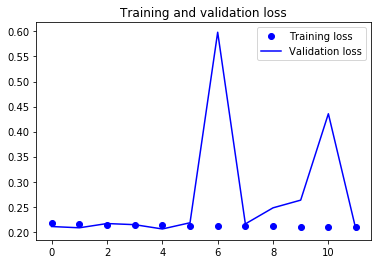

In [107]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(12)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
train_results = encoder.predict(trainImg)

In [0]:
test_results = encoder.predict(testImg)

In [110]:
test_results.shape

(794, 144)

In [0]:
np.savetxt('train.csv', train_results, delimiter=',')

In [113]:
train_results.shape

(6290, 144)